In [1]:
import os
os.system("git clone https://github.com/soerenetler/squad-question-generation.git")
os.system("git clone https://github.com/soerenetler/spacy_target_answer.git")
os.system("git clone https://github.com/soerenetler/crf_target_answer.git")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!(cd squad-question-generation/; git pull)
!(cd crf_target_answer/; git pull)

Already up to date.
Already up to date.


In [3]:
!cp crf_target_answer/Custom.py Custom.py
!cp crf_target_answer/model/evaluation_utils.py evaluation_utils.py

In [4]:
!pip install -r crf_target_answer/requirements.txt --quiet

     |████████████████████████████████| 112kB 4.2MB/s 
     |████████████████████████████████| 747kB 6.3MB/s 


In [5]:
import joblib
import eli5
import pandas as pd
#from FeatureTransformer import FeatureTransformer
import pandas as pd
import ast
import spacy
from Custom import *
from sklearn_crfsuite import metrics
from evaluation_utils import visualize_transitions, print_annotated_text, crf_roc_curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import json

data_folder = "/content/gdrive/MyDrive/mt-qg-data/01_data/preprocessedData/"
dataset = "squad"
NO_SAMPLES = None

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_train_crf.txt') as f:
  data_json = json.load(f)
  train_feature = data_json["x"]
  y_train = data_json["y"]
  token_train = data_json["token"]

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_test_crf.txt') as f:
  data_json = json.load(f)
  test_feature = data_json["x"]
  y_test = data_json["y"]
  token_test = data_json["token"]

In [21]:
best_param={'c1': 10, 'c2': 1000}

crf = Custom_CRF(algorithm='lbfgs',
                  max_iterations=100,
                  min_freq=5,
                  all_possible_transitions=False,
                 **best_param)

In [25]:
%%time
crf.fit(train_feature, io2iob(y_train))

CPU times: user 5min 14s, sys: 1.88 s, total: 5min 16s
Wall time: 5min 14s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Custom_CRF(algorithm='lbfgs', all_possible_states=None,
           all_possible_transitions=False, averaging=None, c=None, c1=10,
           c2=100000, calibration_candidates=None, calibration_eta=None,
           calibration_max_trials=None, calibration_rate=None,
           calibration_samples=None, delta=None, epsilon=None,
           error_sensitive=None, gamma=None, keep_tempfiles=None,
           linesearch=None, max_iterations=100, max_linesearch=None, min_freq=5,
           model_filename=None, num_memories=None, pa_type=None, period=None,
           trainer_cls=None, variance=None, verbose=False)

In [26]:
y_pred_test = crf.predict(test_feature)
y_pred_test_marginals = crf.predict_proba(test_feature)

y_pred_train = crf.predict(train_feature)
y_pred_train_marginals = crf.predict_proba(train_feature)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    B-Answer    0.00000   0.00000   0.00000      8080
    I-Answer    0.00000   0.00000   0.00000     27451
           O    0.79916   1.00000   0.88837    141383

    accuracy                        0.79916    176914
   macro avg    0.26639   0.33333   0.29612    176914
weighted avg    0.63866   0.79916   0.70995    176914



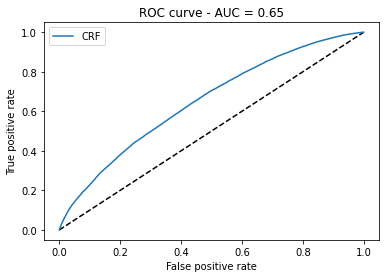

In [27]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(io2iob(y_test), y_pred_test, digits=5))
crf_roc_curve(io2iob(y_test), y_pred_test_marginals)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    B-Answer    0.00000   0.00000   0.00000     76656
    I-Answer    0.00000   0.00000   0.00000    200480
           O    0.86521   1.00000   0.92773   1778924

    accuracy                        0.86521   2056060
   macro avg    0.28840   0.33333   0.30924   2056060
weighted avg    0.74859   0.86521   0.80269   2056060



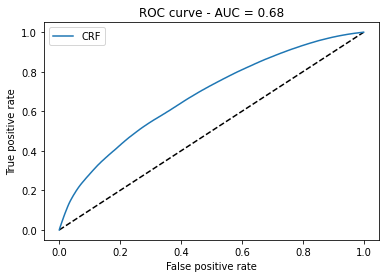

In [28]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(io2iob(y_train), y_pred_train, digits=5))
crf_roc_curve(io2iob(y_train), y_pred_train_marginals)

In [29]:
eli5.show_weights(crf, top=50)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## .......

In [ ]:
print_annotated_text(tokens, y_pred)

In [ ]:
# Print one example output
paragraph = nlp("A Japan-exclusive manga series based on Twilight Princess, penned and illustrated by Akira Himekawa, was first released on February 8, 2016. The series is available solely via publisher Shogakukan's MangaOne mobile application. While the manga adaptation began almost ten years after the initial release of the game on which it is based, it launched only a month before the release of the high-definition remake.")
y_true = ['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

tokens =[token.text for token in paragraph]
y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))
print_annotated_text(tokens, y_pred, y_trues=y_true)

IndexError: list index out of range

In [ ]:
# Print 100 randomly sampled text
from IPython.display import Latex
for index, row in df_askable_paragraph_test.iterrows(): #.sample(n=100, random_state=1)
    if nlp(row["paragraph_context"])[:3].text == "The Norman dynasty":
        paragraph = nlp(row["paragraph_context"])
        y_true = row["askable_tokens"]
        tokens =[token.text for token in paragraph]
        y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))

        print_annotated_text(tokens, y_pred, y_trues=y_true)
        Latex(print_annotated_text_latex(tokens, y_pred, y_trues=y_true))